In [1]:
!pip install ultralytics > /dev/null

In [2]:
import os
import cv2
import shutil
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from ultralytics import YOLO

warnings.filterwarnings("ignore")

TRAIN_IMAGES = Path('/kaggle/input/multi-instance-object-detection-challenge/Starter_Dataset/table_close_10/train/images')
TRAIN_LABELS = Path('/kaggle/input/multi-instance-object-detection-challenge/Starter_Dataset/table_close_10/train/labels')
TEST = Path('/kaggle/input/multi-instance-object-detection-challenge/Starter_Dataset/TestImages/images')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
output_dir = Path("/kaggle/working/predictions/labels")
output_dir.mkdir(parents=True, exist_ok=True)

def visualize_random_masks(images_dir, masks_dir, counts=5):
    image_paths = list(images_dir.glob("*"))
    samples = np.random.choice(image_paths, counts, replace=False)

    plt.figure(figsize=(counts * 5, 8))

    for i, img_path in enumerate(samples, 1):
        mask_path = masks_dir / img_path.with_suffix(".txt").name

        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        with open(mask_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            try:
                class_id, x_center, y_center, box_w, box_h = map(float, parts)
            except:
                class_id, confidence, x_center, y_center, box_w, box_h = map(float, parts)

            x_center *= w
            y_center *= h
            box_w *= w
            box_h *= h

            x1 = int(x_center - box_w / 2)
            y1 = int(y_center - box_h / 2)
            x2 = int(x_center + box_w / 2)
            y2 = int(y_center + box_h / 2)

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 5)

        plt.subplot(1, counts, i)
        plt.imshow(image)
        plt.axis("off")
        plt.tight_layout()

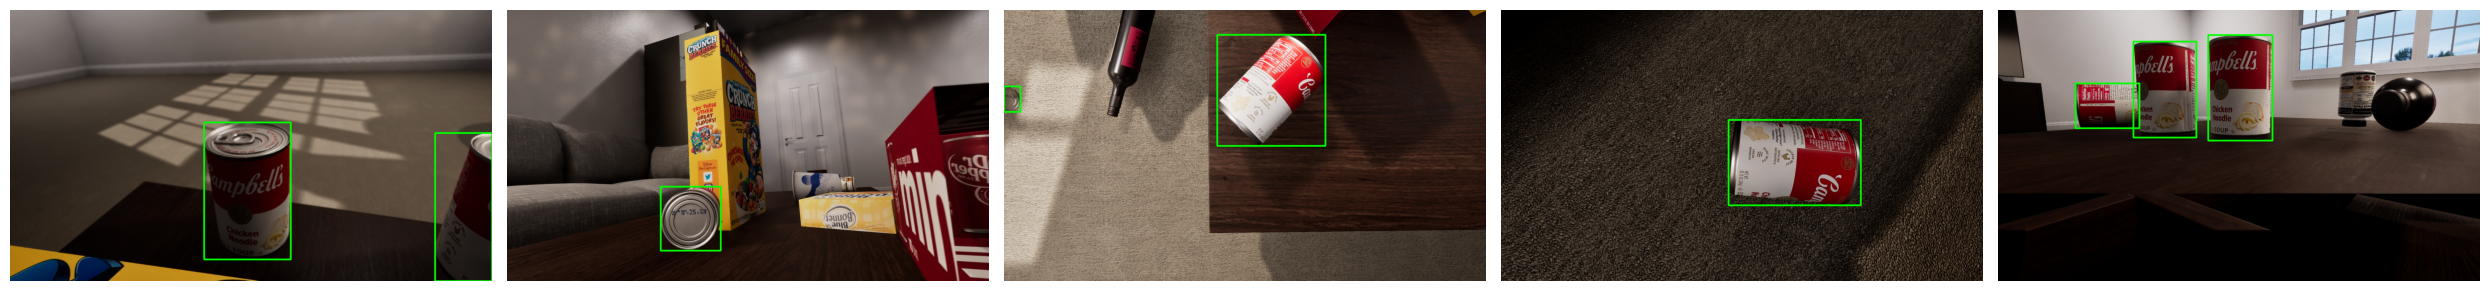

In [4]:
# Show training samples
visualize_random_masks(TRAIN_IMAGES, TRAIN_LABELS)

In [5]:
# Load YOLO model
model = YOLO("yolo11m.pt")
data_yaml = "/kaggle/input/multi-instance-object-detection-challenge/Starter_Dataset/yolo_params.yaml"

# Train model
results = model.train(
    data=data_yaml,
    epochs=150,
    batch=4,
    imgsz=600,
    device=0,  # Kaggle only has one GPU
    patience=10,
    lr0=0.0001,
    lrf=0.02,
    optimizer="Adam",
    weight_decay=0.003,
    cos_lr=True,
    mosaic=0.5,
    mixup=0.15,
    copy_paste=0.1,
    fliplr=0.5,
    flipud=0.5,
    hsv_h=0.015,
    hsv_s=0.1,
    hsv_v=0.1,
    translate=0.2,
    scale=0.5,
    shear=0.2,
    perspective=0.0002,
    val=True,
    workers=8,
    seed=35
)


100%|██████████| 38.8M/38.8M [00:00<00:00, 222MB/s]


Ultralytics 8.3.158 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/input/multi-instance-object-detection-challenge/Starter_Dataset/yolo_params.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.1, hsv_v=0.1, imgsz=600, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.02, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patie

100%|██████████| 755k/755k [00:00<00:00, 18.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 70.2MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[600] must be multiple of max stride 32, updating to [608]
train: Fast image access ✅ (ping: 0.1±0.1 ms, read: 148.4±7.9 MB/s, size: 2729.4 KB)


train: Scanning /kaggle/input/multi-instance-object-detection-challenge/Starter_Dataset/clutter/train/labels... 56 images, 1 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 67.21it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/multi-instance-object-detection-challenge/Starter_Dataset/clutter/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 103.4±33.1 MB/s, size: 4148.6 KB)


val: Scanning /kaggle/input/multi-instance-object-detection-challenge/Starter_Dataset/clutter/val/labels... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<00:00, 55.08it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/multi-instance-object-detection-challenge/Starter_Dataset/clutter/val is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.003), 112 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.14G     0.7859      2.664      1.039         17        608: 100%|██████████| 14/14 [00:03<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         14         28      0.669      0.866       0.74      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150       2.3G     0.6751      1.077      0.939         21        608: 100%|██████████| 14/14 [00:02<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.57it/s]

                   all         14         28       0.64      0.824      0.645      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.36G     0.5704     0.9177     0.9044         10        608: 100%|██████████| 14/14 [00:02<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.76it/s]

                   all         14         28      0.678      0.964      0.708      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      2.49G     0.6007     0.7447     0.9109          9        608: 100%|██████████| 14/14 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.35it/s]

                   all         14         28      0.709      0.958      0.772      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.59G     0.6413      0.694     0.9269         18        608: 100%|██████████| 14/14 [00:02<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.69it/s]

                   all         14         28      0.826      0.847       0.79      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.72G     0.5748     0.6976     0.8621         15        608: 100%|██████████| 14/14 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.21it/s]

                   all         14         28      0.746      0.893      0.851      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.88G     0.6722     0.8517     0.9653         18        608: 100%|██████████| 14/14 [00:02<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.04it/s]

                   all         14         28      0.788      0.928      0.879      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.94G     0.6337     0.6595     0.9271         11        608: 100%|██████████| 14/14 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.59it/s]

                   all         14         28      0.759      0.929      0.897      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      3.07G     0.5911     0.6848     0.8858         10        608: 100%|██████████| 14/14 [00:02<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.29it/s]

                   all         14         28      0.786      0.964      0.916      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      3.17G     0.7014      0.657     0.9352         22        608: 100%|██████████| 14/14 [00:02<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.42it/s]

                   all         14         28      0.845      0.929      0.919      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      3.29G      0.595     0.7738     0.9044          6        608: 100%|██████████| 14/14 [00:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]

                   all         14         28      0.869      0.964      0.935      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150       3.4G     0.5437      0.565     0.8505         15        608: 100%|██████████| 14/14 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.63it/s]

                   all         14         28      0.817       0.96      0.951      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      3.53G     0.5391     0.5268     0.8851         17        608: 100%|██████████| 14/14 [00:02<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.49it/s]

                   all         14         28      0.893      0.891      0.916      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      3.63G     0.5417     0.5339     0.8739         15        608: 100%|██████████| 14/14 [00:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.15it/s]

                   all         14         28      0.893      0.891      0.916      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      3.74G     0.5734     0.5171     0.9149         11        608: 100%|██████████| 14/14 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.57it/s]


                   all         14         28      0.908      0.893       0.93      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      3.89G     0.5825      0.479     0.8937         10        608: 100%|██████████| 14/14 [00:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.66it/s]

                   all         14         28      0.905      0.893      0.955      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      3.98G      0.505     0.4721     0.8715         14        608: 100%|██████████| 14/14 [00:02<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.11it/s]

                   all         14         28        0.9      0.964      0.964      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      4.08G     0.5276     0.5055     0.8472         11        608: 100%|██████████| 14/14 [00:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.37it/s]

                   all         14         28      0.894      0.964      0.962      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      4.21G      0.501     0.4829      0.858          7        608: 100%|██████████| 14/14 [00:02<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.11it/s]


                   all         14         28      0.931      0.962      0.964      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      4.31G     0.4851     0.4859     0.8191         14        608: 100%|██████████| 14/14 [00:02<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.02it/s]

                   all         14         28      0.925      0.964       0.96      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      4.44G     0.5482     0.4985     0.8595         17        608: 100%|██████████| 14/14 [00:02<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.58it/s]

                   all         14         28      0.964      0.951      0.963       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      4.54G     0.5256     0.4969     0.8821         19        608: 100%|██████████| 14/14 [00:02<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.49it/s]

                   all         14         28      0.964      0.951      0.963       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      4.67G     0.4983     0.4584     0.8537         14        608: 100%|██████████| 14/14 [00:02<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.63it/s]

                   all         14         28       0.94      0.964      0.955      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      4.78G     0.4706     0.4287     0.8414          9        608: 100%|██████████| 14/14 [00:02<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.02it/s]

                   all         14         28      0.929      0.964      0.955       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      4.93G     0.4461     0.3921     0.8351         11        608: 100%|██████████| 14/14 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.47it/s]

                   all         14         28       0.94      0.929      0.951      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150         5G     0.4935     0.4304     0.8606         13        608: 100%|██████████| 14/14 [00:02<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.00it/s]

                   all         14         28      0.958      0.964      0.962      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      5.12G     0.5005     0.3824     0.8492          6        608: 100%|██████████| 14/14 [00:02<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.29it/s]

                   all         14         28      0.953      0.964      0.975      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      5.25G     0.4721      0.391     0.8659         11        608: 100%|██████████| 14/14 [00:02<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.85it/s]

                   all         14         28      0.983      0.929      0.976      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      5.35G     0.4867     0.4366     0.8517         14        608: 100%|██████████| 14/14 [00:02<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.59it/s]

                   all         14         28      0.924      0.964      0.973      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      5.46G     0.4693     0.4063     0.8542         10        608: 100%|██████████| 14/14 [00:02<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.93it/s]

                   all         14         28      0.924      0.964      0.973      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      5.58G     0.4808     0.4126     0.8491         11        608: 100%|██████████| 14/14 [00:02<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.30it/s]

                   all         14         28      0.956      0.964      0.973      0.911
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 21, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



31 epochs completed in 0.029 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


                   all         14         28      0.964      0.953      0.963       0.92
Speed: 0.2ms preprocess, 8.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train


In [6]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

In [7]:
for img_path in TEST.glob("*"):
    results = model.predict(img_path, conf=0.05, device=0, verbose=False) # 0 - GPU or "cpu"
    output_txt = output_dir / f"{img_path.stem}.txt"

    with open(output_txt, "w") as f:
        found = False
        for result in results:
            img_height, img_width = result.orig_shape
            boxes = result.boxes.data

            if boxes is None or len(boxes) == 0:
                continue

            filtered_boxes = boxes[boxes[:, 4] >= 0.05]
            if len(filtered_boxes) == 0:
                continue

            found = True
            for box in filtered_boxes:
                x1, y1, x2, y2, confidence, cls_id = box.tolist()

                x_center = ((x1 + x2) / 2) / img_width
                y_center = ((y1 + y2) / 2) / img_height
                width = (x2 - x1) / img_width
                height = (y2 - y1) / img_height

                f.write(f"0 {confidence:.6f} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        if not found:
            f.write("")

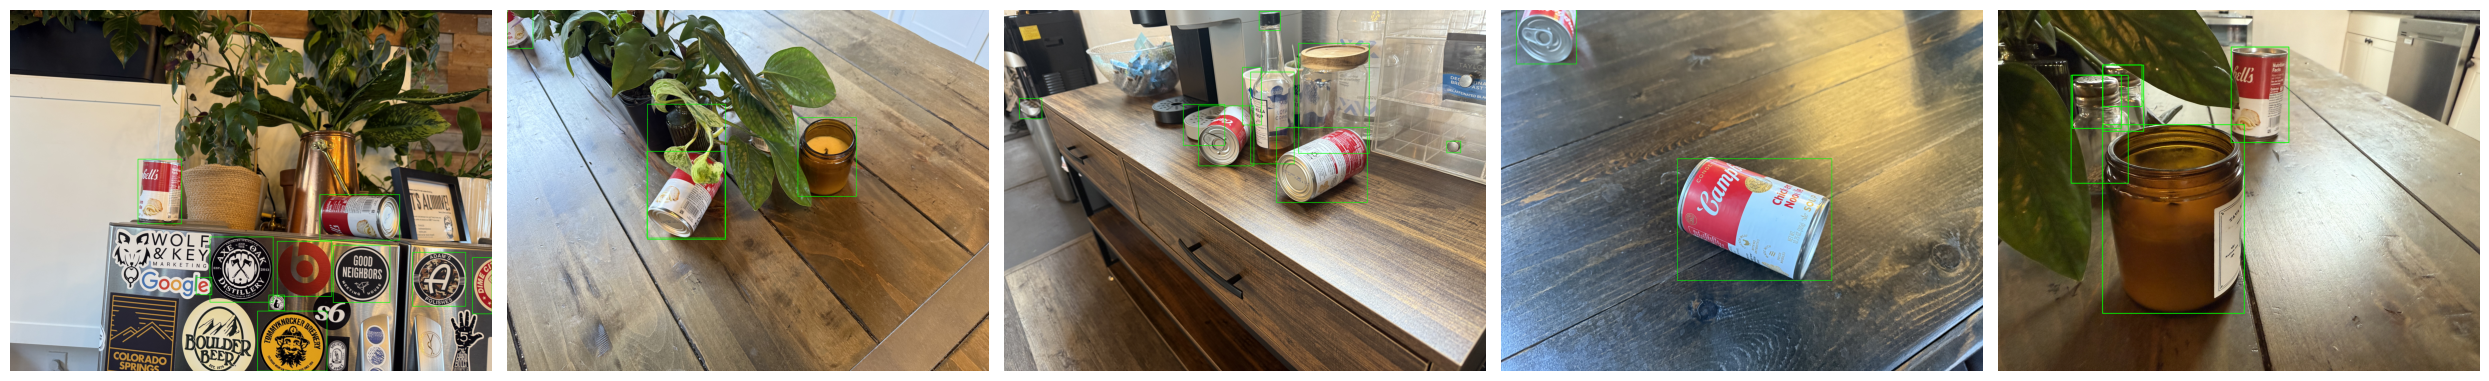

In [8]:
visualize_random_masks(TEST, output_dir)

In [9]:
rows = []
test_imgs = {p.stem for p in TEST.glob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png"}}
predicted = set()

for file in output_dir.glob("*.txt"):
    name = file.stem
    predicted.add(name)

    try:
        lines = [l.strip() for l in open(file) if len(l.strip().split()) == 6]
    except:
        lines = []

    rows.append({"image_id": name, "prediction_string": " ".join(lines) if lines else "no boxes"})

for name in test_imgs - predicted:
    rows.append({"image_id": name, "prediction_string": "no boxes"})

In [10]:
work_dir = '/kaggle/working'

for filename in os.listdir(work_dir):
    file_path = os.path.join(work_dir, filename)

    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Error file: {file_path}. Cause: {e}')

In [11]:
rows = pd.DataFrame(rows)
rows.to_csv("submission.csv", index=False)
rows

,image_id,prediction_string
0,IMG_9562,0 0.936752 0.281053 0.275985 0.076351 0.147985...
1,IMG_9630,0 0.772683 0.633118 0.733761 0.076410 0.131879...
2,IMG_9607,0 0.958374 0.689313 0.472744 0.180725 0.167681...
3,IMG_9569,0 0.913561 0.550770 0.399949 0.083657 0.147811...
4,IMG_9722,0 0.857544 0.394715 0.794467 0.135389 0.191736...
...,...,...
174,IMG_9747,0 0.978906 0.452675 0.729929 0.219112 0.258966...
175,IMG_9683,0 0.996299 0.738041 0.521802 0.246690 0.491279...
176,IMG_9769,0 0.991877 0.314728 0.562536 0.312610 0.655876...
177,IMG_9687,0 0.950903 0.711588 0.270453 0.074044 0.140525...
